# Employee Turn Over - Model training

training process v2

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import joblib
import sys

sys.path.append('../../src/')

from modeleval import binary_eval
warnings.filterwarnings("ignore")


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import shap

In [3]:
PATH_DATA='../../data/raw/'
PATH_DATA_INTERIM='../../data/interim/'
PATH_MODEL = '../../model/iter1/'
VERS = '2'

model_file = PATH_MODEL+'model_'+VERS+'.pkl'

## Get Data

In [4]:
df1 = pd.read_csv(PATH_DATA_INTERIM+'iter1_interim_cln.csv')

In [5]:
## we use 1 as turn over
df1['target'] = (df1.stillExists==False).astype(int)
col_used = list(set(df1.columns)-set(['unique_employee_ids','stillExists','companyAlias','is_train','target']))

col_used.sort() ## --> remember to sort

In [6]:
Xtrain = df1[df1.is_train == 1][col_used]
Ytrain = df1[df1.is_train == 1]['target']

Xtest = df1[df1.is_train == 0][col_used]
Ytest = df1[df1.is_train == 0]['target']

In [7]:
Xtrain.shape, Xtest.shape

((3338, 52), (1431, 52))

In [8]:
1-Ytrain.mean(), 1-Ytest.mean()

(0.768424206111444, 0.7721872816212438)

## Transformation

if needed

In [9]:
SS = StandardScaler()
SS.fit(Xtrain)

joblib.dump(SS, PATH_MODEL+'scaler_'+VERS+'.pkl')

['../../model/iter1/scaler_2.pkl']

In [10]:
Xtrain_ss = pd.DataFrame(SS.transform(Xtrain), columns = col_used)
Xtest_ss = pd.DataFrame(SS.transform(Xtest), columns = col_used)

## Model

In [13]:
tModel = DecisionTreeClassifier()
tModel.fit(Xtrain_ss,Ytrain)

DecisionTreeClassifier()

In [14]:
joblib.dump(tModel, model_file)
tModel_load = joblib.load(model_file)

## Evaluations

In [15]:
%matplotlib inline

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2565
           1       0.99      0.97      0.98       773

    accuracy                           0.99      3338
   macro avg       0.99      0.98      0.99      3338
weighted avg       0.99      0.99      0.99      3338

aucpr :  0.9664
aucroc :  0.9845


(0.9664, 0.9845)

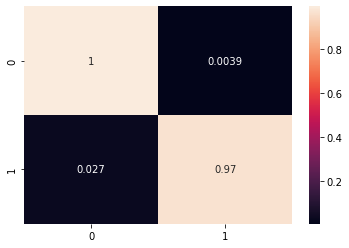

In [16]:
binary_eval(Ytrain, model=tModel_load, predictor=Xtrain_ss)

              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1105
           1       0.75      0.77      0.76       326

    accuracy                           0.89      1431
   macro avg       0.84      0.85      0.84      1431
weighted avg       0.89      0.89      0.89      1431

aucpr :  0.631
aucroc :  0.8474


(0.631, 0.8474)

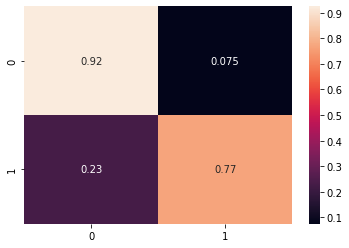

In [17]:
binary_eval(Ytest, model=tModel_load, predictor=Xtest_ss)

## Feature Importance

In [18]:
explainer = shap.TreeExplainer(tModel_load)
# masker = shap.maskers.Independent(data=Xtest_ss)
# explainer = shap.Explainer(
#     tModel_load, masker=masker, feature_names=Xtest_ss.columns, algorithm="linear"
# )
shap_values = explainer.shap_values(Xtrain_ss)

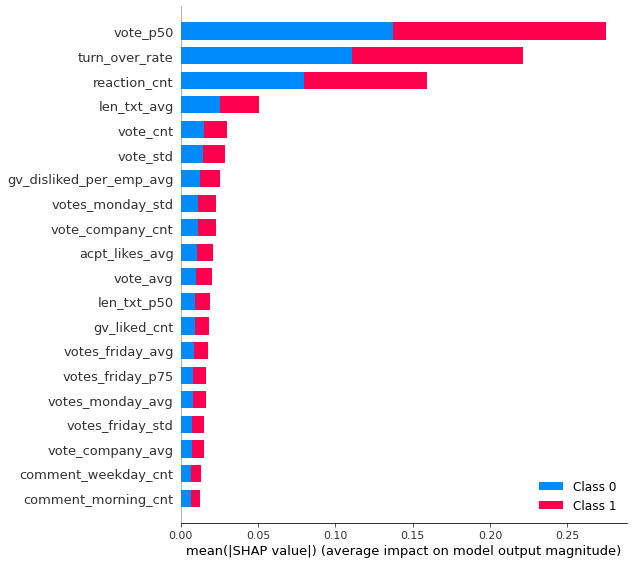

In [19]:
shap.summary_plot(shap_values, features=Xtrain_ss, feature_names=Xtest_ss.columns)

In [20]:
# shap.summary_plot(shap_values, Xtest_ss, plot_type="bar")

In [21]:
# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values, Xtest_ss)

In [22]:
# shap.dependence_plot('vote_avg', shap_values, Xtest_ss)

In [23]:
vals = np.abs(shap_values[0]).mean(0)
feature_names = Xtest_ss.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)

In [24]:
feature_importance.to_csv(PATH_MODEL+'feat_importance_'+VERS+'.csv', index = False)

In [25]:
feature_importance.head()

,col_name,feature_importance_vals
39,vote_p50,0.137350
31,turn_over_rate,0.110741
30,reaction_cnt,0.079749
25,len_txt_avg,0.025293
33,vote_cnt,0.014891
